# Описание проекта

Компания такси собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

# Подготовка

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, SGDRegressor, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import numpy as np
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [18]:
plt.style.use('dark_background')

In [9]:
df = pd.read_csv('taxi.csv', parse_dates=[0], index_col=[0])
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [11]:
df.index.is_monotonic

True

In [12]:
df = df.resample('1H').sum()

In [13]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


##### Загрузку с индексированием по дате и времени провели и рассемплирование сделали. Данные взяты за пол года.

# Анализ

In [14]:
result = seasonal_decompose(df)

In [15]:
type(df)

pandas.core.frame.DataFrame

In [16]:
print(result.trend)
print(result.seasonal)
print(result.resid)
print(result.observed)

datetime
2018-03-01 00:00:00   NaN
2018-03-01 01:00:00   NaN
2018-03-01 02:00:00   NaN
2018-03-01 03:00:00   NaN
2018-03-01 04:00:00   NaN
                       ..
2018-08-31 19:00:00   NaN
2018-08-31 20:00:00   NaN
2018-08-31 21:00:00   NaN
2018-08-31 22:00:00   NaN
2018-08-31 23:00:00   NaN
Freq: H, Name: trend, Length: 4416, dtype: float64
datetime
2018-03-01 00:00:00    60.248112
2018-03-01 01:00:00    20.177074
2018-03-01 02:00:00    28.982743
2018-03-01 03:00:00    17.885407
2018-03-01 04:00:00     2.791145
                         ...    
2018-08-31 19:00:00    -7.124270
2018-08-31 20:00:00    -2.696560
2018-08-31 21:00:00    10.670243
2018-08-31 22:00:00    13.596814
2018-08-31 23:00:00    25.000503
Freq: H, Name: seasonal, Length: 4416, dtype: float64
datetime
2018-03-01 00:00:00   NaN
2018-03-01 01:00:00   NaN
2018-03-01 02:00:00   NaN
2018-03-01 03:00:00   NaN
2018-03-01 04:00:00   NaN
                       ..
2018-08-31 19:00:00   NaN
2018-08-31 20:00:00   NaN
2018-08-31 

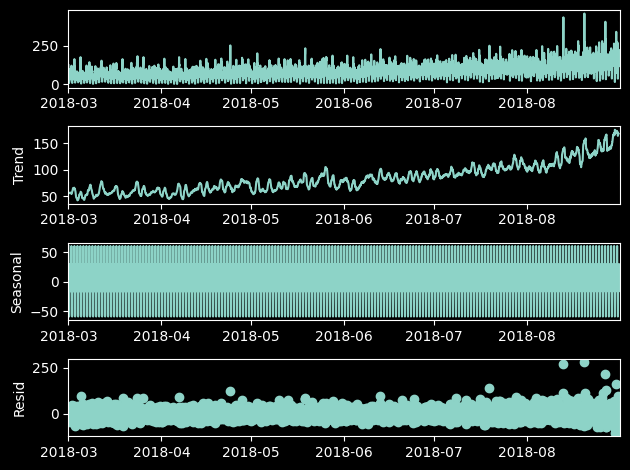

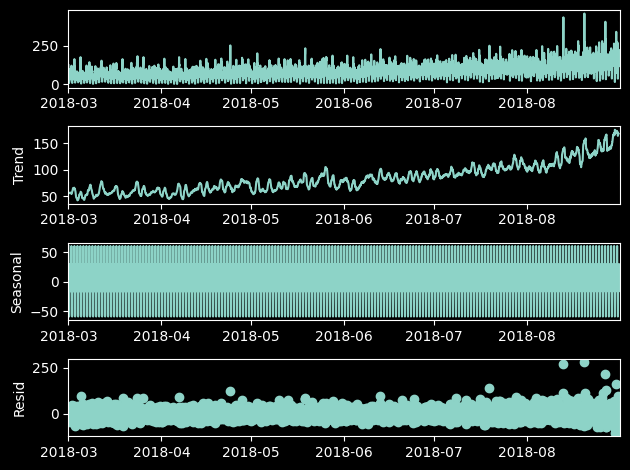

In [19]:
result.plot()

<AxesSubplot:xlabel='datetime'>

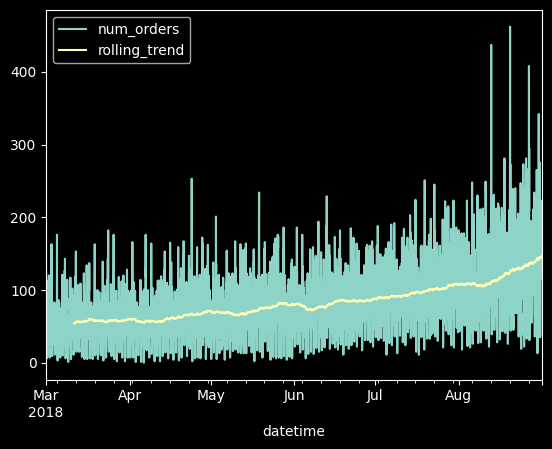

In [20]:
df['rolling_trend'] = df['num_orders'].rolling(250).mean()
df.plot()

Тренд на повышение пользование услугой

<AxesSubplot:xlabel='datetime'>

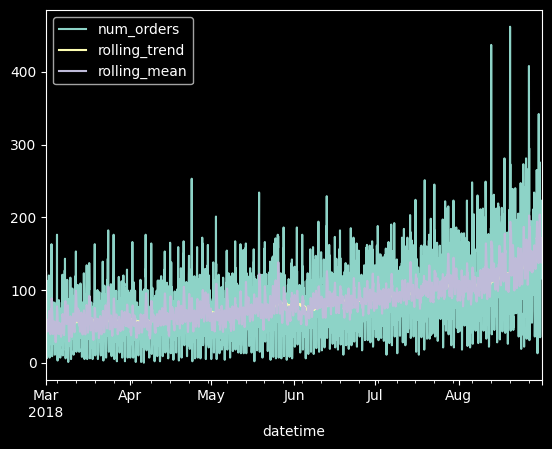

In [21]:
df['rolling_mean'] = df['num_orders'].rolling(12).mean()
df.plot()

Плавающее среднее взято за 12 часов

<AxesSubplot:xlabel='datetime'>

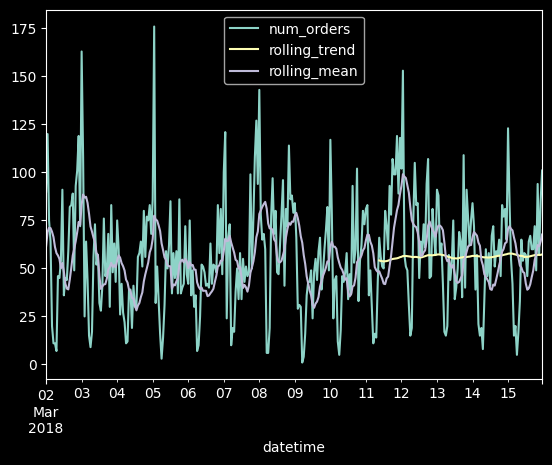

In [22]:
df['2018-03-02':'2018-03-15'].plot()

Почти каждый день повторяются максимумы и минимумы загруженности

<AxesSubplot:xlabel='datetime'>

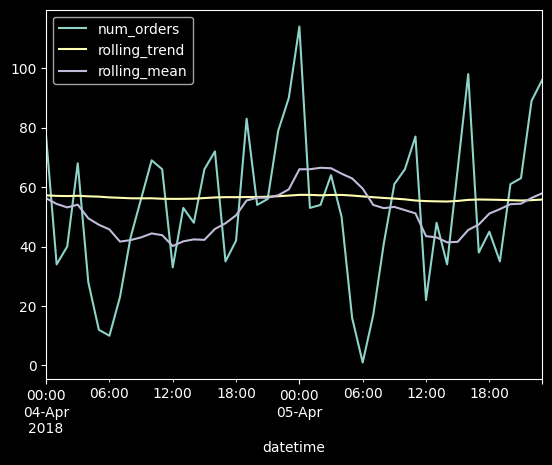

In [23]:
df['2018-04-04':'2018-04-05'].plot()

Максимумы чаще ближе к 12 ночи, а минимумы вседа около 6 утра

<AxesSubplot:xlabel='datetime'>

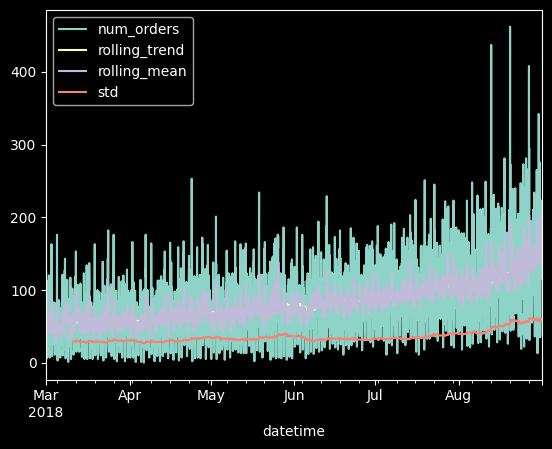

In [24]:
df['std'] = df['num_orders'].rolling(250).std()
df.plot()

<AxesSubplot:xlabel='datetime'>

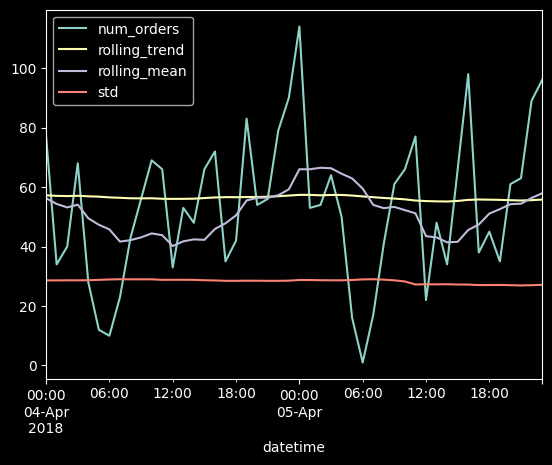

In [25]:
df['2018-04-04':'2018-04-05'].plot()

##### Полугодовой тренд повышается, видна суточная сезонность, особенно минимум, временной ряд нестационарный т.к. его распределение меняется, а именно возрастает среднее и ряд зависит от времени. 

# Обучение

In [26]:
df.head()

,num_orders,rolling_trend,rolling_mean,std
datetime,,,,
2018-03-01 00:00:00,124,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,NaN,NaN


Для начала удалим признак скользящий тренд, скользящее среднее и скользящее среднее отклонение

In [27]:
df = df.drop(['rolling_trend', 'std', 'rolling_mean'], axis=1)

Функция создает признаки:  
  скользящее среднее;  
  задает количество столбцов, лаг временного ряда

In [28]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [29]:
make_features(df, 8, 6)

In [30]:
df.head()

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,rolling_mean
datetime,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,4,3,66.0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN


In [31]:
train, valid_test = train_test_split(df, shuffle=False, test_size=0.2)
valid, test = train_test_split(valid_test, shuffle=False, test_size=0.5)
train = train.dropna()

In [32]:
features_train = train.drop('num_orders', axis=1)
features_valid = valid.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)
target_train = train['num_orders']
target_valid = valid['num_orders']
target_test = test['num_orders']

In [33]:
model = LinearRegression()
model.fit(features_train, target_train)
predicted = model.predict(features_valid)
print(mean_squared_error(predicted, target_valid) ** 0.5)

42.421420752618616


Результат линейной регрессии

In [34]:
for i in range(1,45):
    model = DecisionTreeRegressor(max_depth=i, random_state=12345)
    model.fit(features_train, target_train)
    predicted = model.predict(features_valid)
    print('Количество деревьев', i, mean_squared_error(predicted, target_valid) ** 0.5)

Количество деревьев 1 51.416667013625755
Количество деревьев 2 49.36880974750015
Количество деревьев 3 44.98667130804328
Количество деревьев 4 43.82864624849462
Количество деревьев 5 41.632364656630266
Количество деревьев 6 38.13885739387386
Количество деревьев 7 36.85398346495066
Количество деревьев 8 36.4182706195206
Количество деревьев 9 35.781399382632834
Количество деревьев 10 36.30631298839751
Количество деревьев 11 38.075138756989496
Количество деревьев 12 38.33674839275062
Количество деревьев 13 39.56789495670156
Количество деревьев 14 39.98579148856698
Количество деревьев 15 40.33900588892045
Количество деревьев 16 42.08652473730345
Количество деревьев 17 41.20674678088408
Количество деревьев 18 40.99910932579065
Количество деревьев 19 40.06856542596242
Количество деревьев 20 41.074028928951776
Количество деревьев 21 40.35481770764421
Количество деревьев 22 41.05421279246564
Количество деревьев 23 40.49990223998033
Количество деревьев 24 39.81776928873869
Количество деревьев 2

Лучшая глубина 9 деревьев

In [35]:
%%time
book = {}
for j in range(3, 15):    
    for i in range(4, 100, 10):    
        model = RandomForestRegressor(max_depth=j, n_estimators=i, random_state=12345)
        model.fit(features_train, target_train)
        predicted = model.predict(features_valid)
        rmse = mean_squared_error(predicted, target_valid) ** 0.5
        print('Валидационная выборка: max_depth =', j, 'n_estimators =', i, rmse)
        book[str(i) + ' ' + str(j)] = rmse

Валидационная выборка: max_depth = 3 n_estimators = 4 45.520194008613295
Валидационная выборка: max_depth = 3 n_estimators = 14 44.875094357509546
Валидационная выборка: max_depth = 3 n_estimators = 24 44.46543425849628
Валидационная выборка: max_depth = 3 n_estimators = 34 44.44026008060025
Валидационная выборка: max_depth = 3 n_estimators = 44 44.595377273711044
Валидационная выборка: max_depth = 3 n_estimators = 54 44.58290516150505
Валидационная выборка: max_depth = 3 n_estimators = 64 44.56608833140056
Валидационная выборка: max_depth = 3 n_estimators = 74 44.6042770629752
Валидационная выборка: max_depth = 3 n_estimators = 84 44.625948330649365
Валидационная выборка: max_depth = 3 n_estimators = 94 44.630459472944864
Валидационная выборка: max_depth = 4 n_estimators = 4 42.675163738326496
Валидационная выборка: max_depth = 4 n_estimators = 14 42.62247366046335
Валидационная выборка: max_depth = 4 n_estimators = 24 42.25471556504024
Валидационная выборка: max_depth = 4 n_estimator

In [36]:
print(min(book.values()))
for k, v in book.items():
    if v == min(book.values()):
        print('Деревьев:', k.split()[0])
        print('Максимальная глубина дерева:', k.split()[1])

32.83435898480177
Деревьев: 94
Максимальная глубина дерева: 14


Оптимальные параметры для леса

In [37]:
%%time
for j in range(5, 10):
    model = lgb.LGBMRegressor(max_depht=j, random_state=12345, min_data_in_leaf=10)
    model.fit(features_train, target_train)
    predicted = model.predict(features_valid)
    rmse = mean_squared_error(predicted, target_valid) ** 0.5
    print('максимальная глубина дерева =', j, 'метрика', rmse)    

[LightGBM] [Warning] Unknown parameter: max_depht
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] Unknown parameter: max_depht
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1694
[LightGBM] [Info] Number of data points in the train set: 3524, number of used features: 11
[LightGBM] [Info] Start training from score 74.356413
[LightGBM] [Warning] Unknown parameter: max_depht
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
максимальная глубина дерева = 5 метрика 32.802602284279814
[LightGBM] [Warning] Unknown parameter: max_depht
[LightGBM] [Warning] min_data_in_

У модели LGBM результат не лучше чем у леса, но обучается она намного быстрей чем случайный лес

In [38]:
model = CatBoostRegressor(random_state=12345)
model.fit(features_train, target_train)
predicted = model.predict(features_valid)
print(mean_squared_error(predicted, target_valid) ** 0.5)

Learning rate set to 0.049959
0:	learn: 34.8290287	total: 170ms	remaining: 2m 49s
1:	learn: 34.0590365	total: 172ms	remaining: 1m 25s
2:	learn: 33.4155573	total: 173ms	remaining: 57.5s
3:	learn: 32.8139649	total: 175ms	remaining: 43.5s
4:	learn: 32.2183500	total: 176ms	remaining: 35.1s
5:	learn: 31.6444764	total: 178ms	remaining: 29.4s
6:	learn: 31.0888185	total: 179ms	remaining: 25.4s
7:	learn: 30.6199835	total: 181ms	remaining: 22.4s
8:	learn: 30.1222109	total: 182ms	remaining: 20.1s
9:	learn: 29.6863412	total: 184ms	remaining: 18.2s
10:	learn: 29.2661680	total: 185ms	remaining: 16.7s
11:	learn: 28.8786482	total: 187ms	remaining: 15.4s
12:	learn: 28.4826347	total: 189ms	remaining: 14.3s
13:	learn: 28.1290369	total: 190ms	remaining: 13.4s
14:	learn: 27.7794394	total: 192ms	remaining: 12.6s
15:	learn: 27.4648095	total: 194ms	remaining: 11.9s
16:	learn: 27.1795001	total: 195ms	remaining: 11.3s
17:	learn: 26.9138849	total: 197ms	remaining: 10.7s
18:	learn: 26.6195411	total: 199ms	remaini

Лучше всего подходит случайный лес, LGBM, CatBoost

# Тестирование

In [40]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)
train = train.dropna()

In [41]:
features_train = train.drop('num_orders', axis=1)
features_test = test.drop('num_orders', axis=1)
target_train = train['num_orders']
target_test = test['num_orders']

In [44]:
model = lgb.LGBMRegressor(random_state=12345, min_data_in_leaf=10)
model.fit(features_train, target_train)
predicted = model.predict(features_test)
mean_squared_error(predicted, target_test) ** 0.5

[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1806
[LightGBM] [Info] Number of data points in the train set: 3966, number of used features: 11
[LightGBM] [Info] Start training from score 78.342158
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10


46.77303824374782

(426192.0, 426264.0)

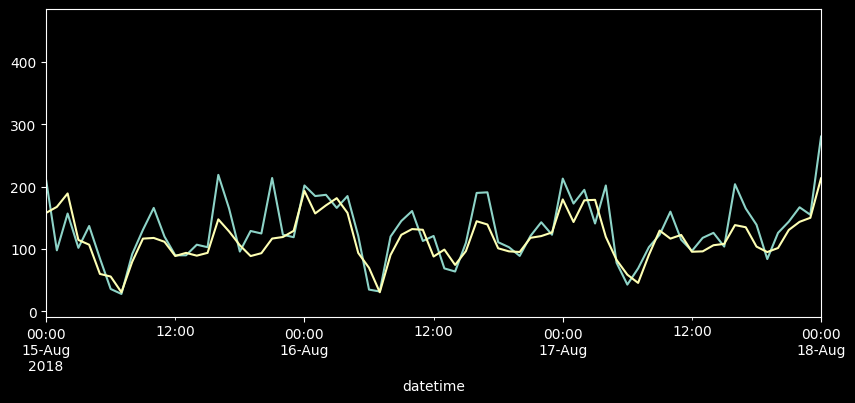

In [45]:
pred = pd.Series(predicted, index=target_test.index)
plt.figure(figsize=(10,4))
target_test.plot()
pred.plot()
plt.xlim('2018-08-15', '2018-08-18')

Данная модель хорошо предсказывает минимумы заказов такси и плохо пики заказов

In [46]:
model = CatBoostRegressor(random_state=12345)
model.fit(features_train, target_train)
predicted = model.predict(features_test)
print(mean_squared_error(predicted, target_test) ** 0.5)

Learning rate set to 0.0509
0:	learn: 37.7025467	total: 15.7ms	remaining: 15.7s
1:	learn: 36.8624950	total: 17.6ms	remaining: 8.78s
2:	learn: 36.1353215	total: 19.2ms	remaining: 6.36s
3:	learn: 35.5566015	total: 21ms	remaining: 5.22s
4:	learn: 34.7928193	total: 22.6ms	remaining: 4.51s
5:	learn: 34.0777548	total: 24.6ms	remaining: 4.07s
6:	learn: 33.4408320	total: 26.8ms	remaining: 3.81s
7:	learn: 33.0233104	total: 28.4ms	remaining: 3.53s
8:	learn: 32.4541507	total: 30ms	remaining: 3.3s
9:	learn: 31.9936077	total: 31.6ms	remaining: 3.13s
10:	learn: 31.5133128	total: 33.1ms	remaining: 2.98s
11:	learn: 31.0701355	total: 34.7ms	remaining: 2.86s
12:	learn: 30.5984198	total: 36.8ms	remaining: 2.8s
13:	learn: 30.2453449	total: 38.6ms	remaining: 2.72s
14:	learn: 29.8779712	total: 40.3ms	remaining: 2.65s
15:	learn: 29.5353498	total: 42.2ms	remaining: 2.6s
16:	learn: 29.2130600	total: 44.1ms	remaining: 2.55s
17:	learn: 28.9532762	total: 45.7ms	remaining: 2.49s
18:	learn: 28.7040268	total: 47.1ms

(426192.0, 426264.0)

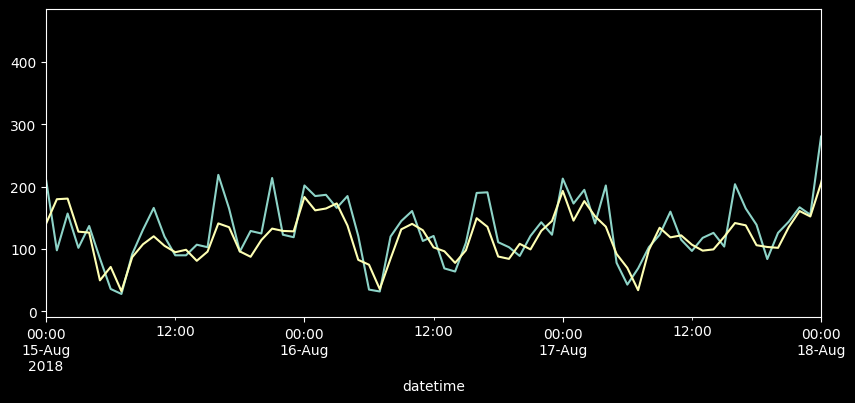

In [47]:
pred = pd.Series(predicted, index=target_test.index)
plt.figure(figsize=(10,4))
target_test.plot()
pred.plot()
plt.xlim('2018-08-15', '2018-08-18')

In [48]:
model = RandomForestRegressor(max_depth=14, n_estimators=94, random_state=12345)
model.fit(features_train, target_train)
predicted = model.predict(features_test)
mean_squared_error(predicted, target_test) ** 0.5

48.52795859789978

(426192.0, 426264.0)

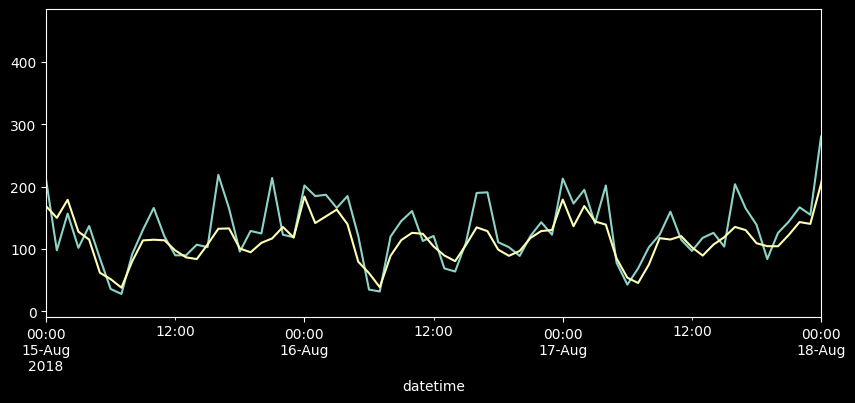

In [49]:
pred = pd.Series(predicted, index=target_test.index)
plt.figure(figsize=(10,4))
target_test.plot()
pred.plot()
plt.xlim('2018-08-15', '2018-08-18')

# Вывод

Лучше всего себя проявила модель CatBoost так сказать из коробки. Случайный лес хорошо проявил себя на валидации скорее всего случайно, а на тесте показал худший результат.